In [2]:
%matplotlib inline
import os
import numpy as np
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from scipy.sparse import csr_matrix
import networkx as nx

from scipy.linalg import orthogonal_procrustes

import torch
import torch.optim as optim
from torch_geometric.data import Data

from sklearn.manifold import TSNE
from sklearn.datasets import make_moons  

from util import Net, GIN, GAT, stationary, reconstruct, dG, GCN
from torch.nn import MSELoss


np.random.seed(0)
torch.manual_seed(0)

n = 2000
m = 500
# DISTANCE = 0.1

# 导入moon数据集
x, y = make_moons(n_samples=n, noise=0.1, random_state=0) 
# 分割训练集和测试机
n_train = int(n * 0.7)
train_ind = torch.randperm(n)[:n_train]
test_ind = torch.LongTensor(list(set(np.arange(n)) - set(train_ind.tolist())))
D = pairwise_distances(x)  # Assuming you have defined pairwise_distances elsewhere
MAX_DISTANCE = max_value = np.max(D)

print(f"Train size: {n_train}\nTest size: {n-n_train}")
print("Max value in adjacency matrix:", MAX_DISTANCE)



Train size: 1400
Test size: 600
Max value in adjacency matrix: 3.5395762266353823


In [3]:
from torchmetrics import Accuracy

accuracy = Accuracy(task='binary')

def get_accs(function: str, distance):
    A_binary = np.where(D <= distance, 1, 0)
    row_indices, col_indices = np.where(A_binary == 1)
    edges = list(zip(row_indices, col_indices))
    # Convert to tensors
    x_tensor = torch.tensor(x, dtype=torch.float)
    y_tensor = torch.tensor(y, dtype=torch.long)
    edges_tensor = torch.tensor(edges, dtype=torch.long).t().contiguous()
    data = Data(x=x_tensor, y=y_tensor, edge_index=edges_tensor)

    function = eval(function)
    net = function(m)
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    net.train()

    for epoch in range(30):
        ind = torch.eye(n)[:, torch.randperm(n)[:m]]
        X_extended = torch.hstack([x_tensor, ind])
        data = Data(x=X_extended, edge_index=edges_tensor)
        rec = net(data)
        loss = dG(x_tensor[train_ind], rec[train_ind])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Predict labels for the test set
    net.eval()
    with torch.no_grad():
        rec_test = net(data)
        pred_labels = torch.argmax(rec_test[test_ind], dim=1)
    # Calculate accuracy
    acc = accuracy(pred_labels, y_tensor[test_ind])
    return acc


In [ ]:
# Import necessary libraries
from tqdm.auto import tqdm
import json

# Define epsilon range
eps_range = [eps for eps in np.arange(0.01, MAX_DISTANCE/2, 0.1)]

# Initialize dictionaries to store accuracy results
accs_GCN = {}
accs_GIN = {}
accs_GAT = {}

# Iterate over epsilon values
for eps in tqdm(eps_range):
    accs_GCN[eps] = get_accs('GCN', eps)
    with open('./results/t_accs_GCN_moon.txt', 'a') as file:
        file.write(f"{eps}\t{accs_GCN[eps]}\n")
    accs_GIN[eps] = get_accs('GIN', eps)
    with open('./results/t_accs_GIN_moon.txt', 'a') as file:
        file.write(f"{eps}\t{accs_GIN[eps]}\n")
    accs_GAT[eps] = get_accs('GAT', eps)
    with open('./results/t_accs_GAT_moon.txt', 'a') as file:
        file.write(f"{eps}\t{accs_GAT[eps]}\n")

# Convert tensors to lists
accs_GCN_serializable = {str(k): v.tolist() for k, v in accs_GCN.items()}
accs_GIN_serializable = {str(k): v.tolist() for k, v in accs_GIN.items()}
accs_GAT_serializable = {str(k): v.tolist() for k, v in accs_GAT.items()}

# Write results to text files
with open('./results/accs_GCN_moon.txt', 'w') as file:
    file.write(json.dumps(accs_GCN_serializable))

with open('./results/accs_GIN_moon.txt', 'w') as file:
    file.write(json.dumps(accs_GIN_serializable))

with open('./results/accs_GAT_moon.txt', 'w') as file:
    file.write(json.dumps(accs_GAT_serializable))


In [ ]:
import matplotlib.pyplot as plt
import json

# Load accuracy data from text files
with open('./results/accs_GCN_moon.txt', 'r') as file:
    accs_GCN = json.load(file)

with open('./results/accs_GIN_moon.txt', 'r') as file:
    accs_GIN = json.load(file)

with open('./results/accs_GAT_moon.txt', 'r') as file:
    accs_GAT = json.load(file)

# Extract epsilon values and corresponding accuracies
eps_values = list(eval(i) for i in accs_GCN.keys())
accs_values_GCN = list(accs_GCN.values())
accs_values_GIN = list(accs_GIN.values())
accs_values_GAT = list(accs_GAT.values())

# Plot the accuracies
plt.plot(eps_values, accs_values_GCN, label='GCN')

# Add labels and title
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.title('Accuracy of GCN eps blob')

# Add legend
plt.legend()

# Show plot
plt.grid(True)
plt.savefig("./results/eps_blob_GCN_moon.jpg")
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: './results/accs_GCN_moon.txt'

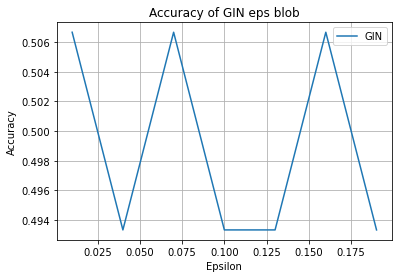

In [ ]:
# Plot the accuracies
plt.plot(eps_values, accs_values_GIN, label='GIN')

# Add labels and title
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.title('Accuracy of GIN eps blob')

# Add legend
plt.legend()

# Show plot
plt.grid(True)
plt.savefig("./results/eps_blob_GIN_moon.jpg")
plt.show()


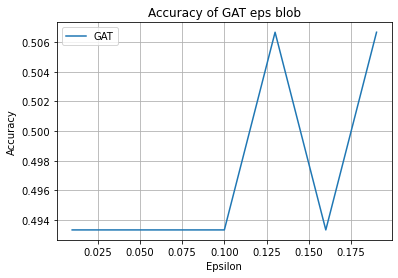

In [ ]:
# Plot the accuracies
plt.plot(eps_values, accs_values_GAT, label='GAT')

# Add labels and title
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.title('Accuracy of GAT eps blob')

# Add legend
plt.legend()

# Show plot
plt.grid(True)
plt.savefig("./results/eps_blob_GAT_moon.jpg")
plt.show()


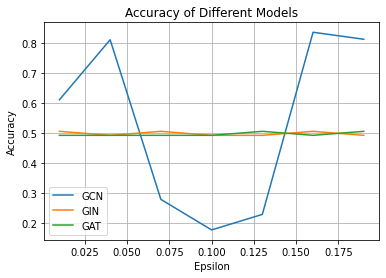

In [ ]:
import matplotlib.pyplot as plt
import json

# Load accuracy data from text files
with open('./results/accs_GCN_moon.txt', 'r') as file:
    accs_GCN = json.load(file)

with open('./results/accs_GIN_moon.txt', 'r') as file:
    accs_GIN = json.load(file)

with open('./results/accs_GAT_moon.txt', 'r') as file:
    accs_GAT = json.load(file)

# Extract epsilon values and corresponding accuracies
eps_values = list(eval(i) for i in accs_GCN.keys())
accs_values_GCN = list(accs_GCN.values())
accs_values_GIN = list(accs_GIN.values())
accs_values_GAT = list(accs_GAT.values())

# Plot the accuracies
plt.plot(eps_values, accs_values_GCN, label='GCN')
plt.plot(eps_values, accs_values_GIN, label='GIN')
plt.plot(eps_values, accs_values_GAT, label='GAT')

# Add labels and title
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Models')

# Add legend
plt.legend()

# Show plot
plt.grid(True)
plt.savefig("./results/eps_blob_res_moon.jpg")
plt.show()
